# Exploratory data analysis for MAPS

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [15]:
from src import constants as C

In [16]:
_FILE_IN = "data/interim/cds_all_possible_snvs_annotated.tsv.gz"
_USECOLS = [
    "Consequence",
    "REGION",
    "Coverage",
    "AC",
    "MR",
    "MR_scaled",
    "MG",
    "PN",
]
_DTYPES = {
    "Consequence": "category",
    "REGION": "category",
    "Coverage": np.float16,
    "AC": np.float16,
    "AF": np.float16,
    "MR": np.float16,
    "MR_scaled": np.float16,
    "MG": np.float16,
    "PN": "category",
}

In [17]:
df = pd.read_csv(
    _FILE_IN,
    sep="\t",
    usecols=_USECOLS,
    na_values=".",
    dtype=_DTYPES,
    # nrows=10000,
)

m1 = df["AC"] > 0
m2 = df["Coverage"] >= 20

df = df[m1 & m2].drop("Coverage", axis=1)

/mnt/iusers01/bk01/m40482ab/miniforge3/envs/ukb/lib/python3.8/site-packages/pandas/io/parsers/c_parser_wrapper.py:230: RuntimeWarning: overflow encountered in cast
  chunks = self._reader.read_low_memory(nrows)
/mnt/iusers01/bk01/m40482ab/miniforge3/envs/ukb/lib/python3.8/site-packages/pandas/io/parsers/c_parser_wrapper.py:230: RuntimeWarning: overflow encountered in cast
  chunks = self._reader.read_low_memory(nrows)
/mnt/iusers01/bk01/m40482ab/miniforge3/envs/ukb/lib/python3.8/site-packages/pandas/io/parsers/c_parser_wrapper.py:230: RuntimeWarning: overflow encountered in cast
  chunks = self._reader.read_low_memory(nrows)
/mnt/iusers01/bk01/m40482ab/miniforge3/envs/ukb/lib/python3.8/site-packages/pandas/io/parsers/c_parser_wrapper.py:230: RuntimeWarning: overflow encountered in cast
  chunks = self._reader.read_low_memory(nrows)
/mnt/iusers01/bk01/m40482ab/miniforge3/envs/ukb/lib/python3.8/site-packages/pandas/io/parsers/c_parser_wrapper.py:230: RuntimeWarning: overflow encountered 

In [18]:
syn = df[df["Consequence"] == "synonymous_variant"].copy()

In [41]:
def get_ps(df, grouping="MR_scaled", mu="MR_scaled"):
    """Get proportion of singletons."""

    grouped = df.groupby(grouping)
    
    ps = (
        grouped.agg(
            n_variants=("AC", "count"),
            n_singletons=("AC", lambda x: (x == 1).sum()),
            mu=(mu, np.mean)
        )
        .assign(ps=lambda x: x["n_singletons"] / x["n_variants"])
        .reset_index(drop=False)
    )

    return ps

In [55]:
def transform_mu(df, transform=lambda x: x):
    return df.assign(mu = lambda x: transform(x.mu))

In [56]:
def tidy_ps(df):
    
    return df.query("ps != 0").query("n_variants > 100")

In [57]:
def fit_lm(df, weighted=True, **kwargs):
    """Fit a polynomial to proportion singletons vs mutation rate."""

    kwargs.update(deg=1)

    x = df["mu"]
    y = df["ps"]
    w=None
    if weighted:
        w = df["n_variants"]
        
    z = np.polyfit(x, y, w=w, **kwargs)
    
    return np.poly1d(z)


In [58]:
def pred_ps(df, poly1d, **kwargs):
    """Find the expected proportion of singletons for a given mutation rate."""

    if not poly1d:
        # For modelling synonymous variants
        poly1d = fit_lm(df)

    df["pred_ps"] = poly1d(df["mu"])

    return df

In [59]:
def plot_ps(df, ax=None, title="Roulette"):
    if not ax: ax = plt.gca()

    df = df.sort_values("mu")

    x = df["mu"].astype(float)
    y = df["ps"]
    # fitted_ps = df["pred_ps"]

    ax.scatter(x, y)
    # ax.plot(x, fitted_ps)
    ax.set_title(title)
    ax.set_xlabel("Mutability")
    ax.set_ylabel("Proportion singletons")

    return ax

In [60]:
def get_maps(df):
    df["maps"] = df["ps"] - df["pred_ps"]
    return df

In [61]:
mr = get_ps(syn, "MR", "MR").pipe(tidy_ps).pipe(pred_ps, poly1d=0)
sr = get_ps(syn, "MR_scaled", "MR_scaled").pipe(tidy_ps).pipe(pred_ps, poly1d=0)
mg = get_ps(syn, "MG", "MG").pipe(tidy_ps).pipe(pred_ps, poly1d=0)
pn = get_ps(syn, "PN", "MR").pipe(tidy_ps).pipe(pred_ps, poly1d=0)


<Axes: title={'center': 'PN'}, xlabel='Mutability', ylabel='Proportion singletons'>

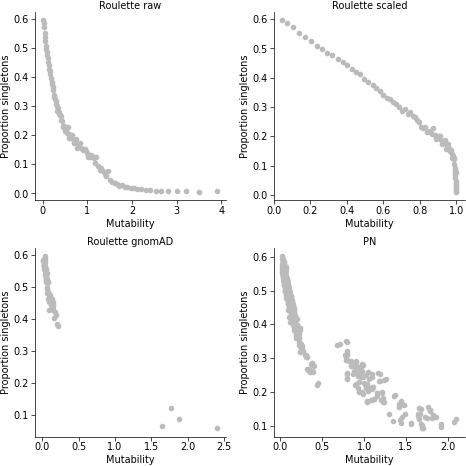

In [62]:
plt.style.use(C.STYLE_DEFAULT)
plt.style.use(C.COLOR_REGIONS)

fig, axs = plt.subplots(2,2, layout="constrained",figsize=(12*C.CM, 12*C.CM))
axs = axs.flatten()

plot_ps(mr, axs[0], "Roulette raw")
plot_ps(sr, axs[1], "Roulette scaled")
plot_ps(mg, axs[2], "Roulette gnomAD")
plot_ps(pn, axs[3], "PN")


This figure suggests a couple of choices for modelling the proportion of singletons by mutation rate.
1) Use a log-linear model with raw Roulette scores. This possibly has a poor fit around central mutability values.
2) A linear model with the scaled Roulette mutation rates. This is attractive but the linear relationship does not hold for very high values of mu.
3) The old gnomAD data, probably split by CpG contexts. This is not very appealing.
4) Separate log-linear models based on pentamer contexts. Again this is not appealing.

What are the mean scaled mutation rates for different variant classes?

All mutation types have middling mean mutation rates. A simple linear model (option 2) could work.

In [74]:
sr_log = get_ps(syn, "MR_scaled", "MR_scaled").pipe(tidy_ps).pipe(transform_mu, np.log).pipe(pred_ps, poly1d=0)
sr_sqrt = get_ps(syn, "MR_scaled", "MR_scaled").pipe(tidy_ps).pipe(transform_mu, np.sqrt).pipe(pred_ps, poly1d=0)
sr_exp = get_ps(syn, "MR_scaled", "MR_scaled").pipe(tidy_ps).pipe(transform_mu, np.exp).pipe(pred_ps, poly1d=0)
mr_log = get_ps(syn, "MR", "MR").pipe(tidy_ps).pipe(transform_mu, np.log).pipe(pred_ps, poly1d=0)
mr_sqrt = get_ps(syn, "MR", "MR").pipe(tidy_ps).pipe(transform_mu, np.sqrt).pipe(pred_ps, poly1d=0)
mr_square = get_ps(syn, "MR", "MR").pipe(tidy_ps).pipe(transform_mu, np.square).pipe(pred_ps, poly1d=0)

<Axes: title={'center': 'square(Roulette raw)'}, xlabel='Mutability', ylabel='Proportion singletons'>

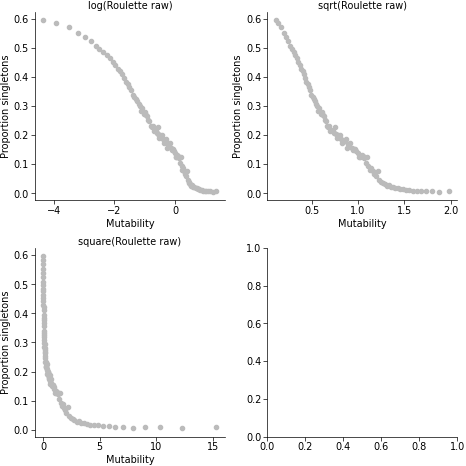

In [75]:
fig, axs = plt.subplots(2,2, layout="constrained",figsize=(12*C.CM, 12*C.CM))
axs = axs.flatten()

plot_ps(mr_log, axs[0], "log(Roulette raw)")
plot_ps(mr_sqrt, axs[1], "sqrt(Roulette raw)")
plot_ps(mr_square, axs[2], "square(Roulette raw)")

## Linear model using scaled Roulette mutation rate

In [ ]:
# Create the model
slope, y_intercept = p = syn.pipe(get_ps).pipe(fit_lm, weighted=True)


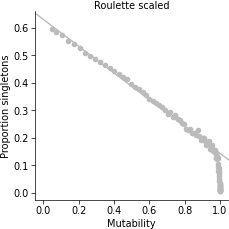

In [ ]:
fig, ax = plt.subplots(1,1, layout="constrained", figsize=(6*C.CM, 6*C.CM))

plot_ps(sr, title="Roulette scaled")
ax.axline(xy1=(0, y_intercept), slope=slope)

After several trials, a weighted linear model which includes all mutational contexts appears to be the most useful for MAPS.

In [ ]:
transcript_level = get_ps(df, "Consequence").pipe(pred_ps, poly1d=p).pipe(get_maps)
transcript_level

,Consequence,n_variants,n_singletons,mu,ps,pred_ps,maps
0,missense_variant,12107704,5838485,0.342493,0.482212,0.462528,0.019684
1,stop_gained,419618,235440,0.344448,0.561082,0.461576,0.099505
2,synonymous_variant,5453797,2359237,0.386340,0.432586,0.441180,-0.008593


In [ ]:
region_level = get_ps(df, ["Consequence", "REGION"]).pipe(pred_ps, poly1d=p).pipe(get_maps)
region_level

,Consequence,REGION,n_variants,n_singletons,mu,ps,pred_ps,maps
0,missense_variant,distal_nmd,2685011,1271302,0.342040,0.473481,0.462749,0.010733
1,missense_variant,long_exon,1011663,480191,0.333127,0.474655,0.467088,0.007567
2,missense_variant,nmd_target,7283862,3542980,0.345017,0.486415,0.461299,0.025116
3,missense_variant,start_proximal,1127168,544012,0.335670,0.482636,0.465850,0.016786
4,stop_gained,distal_nmd,99995,53552,0.327252,0.535547,0.469949,0.065598
5,stop_gained,long_exon,25795,15539,0.323215,0.602404,0.471914,0.130489
6,stop_gained,nmd_target,253524,143945,0.356930,0.567777,0.455499,0.112278
7,stop_gained,start_proximal,40304,22404,0.322190,0.555875,0.472413,0.083462
8,synonymous_variant,distal_nmd,1186192,507851,0.389065,0.428136,0.439853,-0.011717
9,synonymous_variant,long_exon,432928,187458,0.381243,0.433000,0.443661,-0.010661


In [ ]:
# Add confidence intervals to these estimates.